#TP Méthodes des différences temporelles -- SARSA et Q-Learning

## Frozen Lake

l'environnement Frozen Lake est un monde grille incertain dans lequel on part depuis un état initial (la case la plus en haut à gauche) pour aller à un état final (la case la plus basse à droite). L'environnement est incertain car vous marchez sur un lac gelé et l'épaisseur de glace varie. Vous pouvez donc tomber dans l'eau dans certaines cases. De plus, la glace est plus glissante à certains endroits, et donc faire un pas peut vous mener plus loin que prévu... et si le vent s'en mèle...

Au lieu d'essayer d'estimer le modèle de transition, on va utiliser SARSA et Q-learning pour résoudre ce problème.

Utilisez l'environnement Frozen Lake pour implémenter SARSA et Q-learning. Utilisez d'abord l'environnement avec une grille 4x4 pour tester vos algorithmes, puis vous devriez pouvoir les utiliser pour la grille 16x16.



## FrozenLake - familiarisation avec l'environnement

Evaluez une politique aléatoire. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

import gym
from tqdm import tqdm
env = gym.make("FrozenLake8x8-v0",  is_slippery=True)
numStates = env.observation_space.n
numActions = env.action_space.n
print("Environnement avec ", numStates, " états et ", numActions, " actions")
env.reset()
nbIt=0
rew=[]
done=False
while not done:
  observation, reward, done, info = env.step(np.random.randint(4))
  # env.render()
  nbIt+=1
  rew = rew+[reward]
print("Episode terminé après {} itérations".format(nbIt))
print("Récompenses obtenues:",rew)
env.close()

Environnement avec  64  états et  4  actions
Episode terminé après 24 itérations
Récompenses obtenues: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## SARSA

### $\epsilon$-greedy

Implémentez une fonction qui chosit une action avec la stratégie $\epsilon$-greedy:
* exploite avec un probabilité $1-\epsilon$: ici on choisit l'action avec la meilleure valeur de $q[s]$
* explore avec une probabilité $\epsilon$: on choisit une action de manière uniforme sur toute les actions.

### SARSA

Implémentez un fonction SARSA qui prend en paramètre
 * un nombre d'épisodes utilisés pour l'apprentissage
 * $\gamma$ le taux d'escompte
 * $\alpha$ le taux d'apprentissage (que l'on retrouve lors de la mise à jour des valeurs de Q)
 * $\epsilon$ le paramètre pour la méthode $\epsilon$-greedy.

Votre fonction doit au moins retourner la table $Q: S \times A$. Vous trouverez ci-dessous une fonction $plotQ$ qui génère une représentation de la table $Q$: pour chaque case sera dessiné la meilleure action selon $Q$ et la couleur représentera la valeur de cette action.
 
Pour visualiser les progrès faits pendant l'apprentissage, votre fonction SARSA peut également retourner une séquence de valeurs. Par exemple,
 * la séquence de récompenses (totale ou moyenne) obtenue sur chaque épisode de l'apprentissage
 * la valeur de la meilleure action pour l'état de départ à chaque fin d'épisode.
 * au lieu d'utiliser les valeurs obtenues lors de l'apprentissage, vous pouvez aussi effectuer périodiquement une évaluation de la politique courante (sans exploration). Pour ce faire, vous pouvez calculer la performance sur un petit nombre d'épisodes et retourner la moyenne. Cette méthode a l'avantage d'évaluer la politique sans exploration (donc une meilleure évaluation de la politique), mais peut coûter cher en temps de calcul suivant la fréquence d'exécution et le nombre d'épisodes utilisés pour l'évaluation.

En générant le graphique, vous devriez visualiser si l'algorithme est arrivé à améliorer les performances. Vous pouvez soit tracer directement la valeur de chaque épisode. Pour avoir une courbe un peu plus lisse, vous pouvez aussi calculer une moyenne sur une fenêtre de $k$ épisodes (la fonction $runningAvg$ effectue ce travail).

Notez qu'on considère Frozen lake comme résolu quand
 * il atteint le but dans 78% des épisodes pour la grille 4x4.
 * a priori, on peut atteindre 100% pour la grille 8x8

Quelques idées pour aider au debeug:
 * vous pouvez aussi regarder si la plupart des paires état-actions ont été exécutée. 
 * Vous pouvez choisir comme paramètres (le code que j'ai écrit a fonctionné avec ces paramètres, évidemment, vous pouvez essayer avec d'autres par la suite).
   * $\epsilon=0.2$
   * $\alpha=0.02$


In [2]:
# Choix d'une action avec la méthode Epsilon Greedy
def epsGreedy(epsilon, q):
  exploration = np.random.binomial(1,epsilon)

  if exploration:
      return env.action_space.sample()
  else:
      maxs = np.argwhere(q == np.max(q)).ravel()
      if len(maxs) > 1:
        #quand le argmax n'est pas unique
        return np.random.choice(maxs)
      else:
        return np.argmax(q)

def softmax(q):    
    totals = q.sum(axis=1)
    successes = q[:, 0]
    empirical_means = successes / totals
    total_counts = q.sum()
    
    # taux adaptatif
    tau = 1 / np.log(total_counts + 0.000001)

    probs_n = np.exp(empirical_means / tau)
    probs_d = probs_n.sum()
    probs = probs_n / probs_d

    cum_prob = 0.
    z = np.random.rand()
    for idx, prob in enumerate(probs):  
        cum_prob += prob
        if cum_prob > z:
            return idx


La fonction *exploitation_politique* ci-dessous permet d'évaluer la politique obtenue en l'exploitant constamment de façon "gloutonne" (sans explororation $\epsilon = 0$)

In [3]:
#Exploitation de la politique
def exploitation_politique(numEpisodes, gamma, q):
  recompenses = []
  for episode in range(numEpisodes):
    gameover = False
    state = env.reset()
    s = state
    a = np.argmax(q[s,:])
    Gt = 0.0
    k = 0

    while True:
      #Execution de l'action a et observation de la récompense immédiate r      
      s, r, gameover, info = env.step(a)
      Gt += r 

      if gameover:
      # Episode terminée
        break
      
      #Exploitation de la politique
      a = np.argmax(q[s,:])
      k+=1  

    recompenses.append(Gt)

  return recompenses

L'algorithme SARSA (ci-dessous) est une méthode "on-policy", cela signifie que l'on utilise directement la politique que l'on améliore pour génerer les données.

Pour la valeur de $ϵ$, nous prenons 0.2, c'est-à-dire 20% du temps en mode exploration (l'action est choisie aléatoirement). Pour le problème frozen-lake, il faut suffisamment d'exploration pour pouvoir atteindre la cible au moins une fois. Sans récompenses, les valeurs de $Q$ ne seront jamais mises à jour.

Pendant l'apprentissage, tous les 1000 épisodes, la politique actuelle est évaluée sur 20 épisodes (sans exploration) et la moyenne des récompenses est enregistrée. Cela permet de vérifier que l'agent s'améliore au fur et à mesure de l'apprentissage.



In [10]:
def SARSA(numEpisodes, gamma, alpha, epsilon, mode_degressif="off", debut_degressif=0,
          intervalle = 10000,tau_alpha=2, tau_epsilon=1.1, evaluation_politique=False,nb_episode_evaluation=500, evaluation_tous_les=1000):
  recompenses = []
  evaluations = []
  lancement_du_compteur = False

  #compteur pour le mode dégressif
  cpt = 1
  #compteur pour l'évaluation régulière sur quelques épisodes
  cpt_evaluation = 0

  # Initialise q(s, a) ∈ R arbitrairemen
  q = np.zeros((numStates,numActions), dtype='float')  

  
  for episode in tqdm(range(numEpisodes)):
    # aller à l’état initial s
    s = env.reset()
    # choisir action a∈A pour s à l’aide d’une politique dérivée de q
    a = epsGreedy(epsilon, q[s,:])
    Gt = 0.0
    k = 0
    
    if lancement_du_compteur :  
      cpt += 1
    if mode_degressif == "pallier":
      if episode > debut_degressif:
        lancement_du_compteur = True

      if cpt > intervalle:
        cpt = 0
        alpha =  max(0.01,alpha/tau_alpha) 
        epsilon =  max(0.15,epsilon/tau_epsilon) 
    elif mode_degressif == "continu":
      if episode > debut_degressif:
        lancement_du_compteur = True
        epsilon =  max(0.01,epsilon/np.log(cpt+1)) 


      

    if evaluation_politique:
      if cpt_evaluation > evaluation_tous_les:
        cpt_evaluation = 0
        recompenses_exploitation = exploitation_politique(nb_episode_evaluation, gamma=1, q=q)
        evaluations.append(np.mean(recompenses_exploitation))        

    cpt_evaluation += 1

    # Répète pour chaque étape de l’épisode
    while True:
      #Execution de l'action a et observation de r      
      s_p, r, gameover, info = env.step(a)
      Gt += r 

      # Si s_p est final
      if gameover:
        q[s,a] = q[s,a]+ alpha*(r-q[s,a])
        break
      
      #On choisir une action a_p depuis s_p à partir
      #de la politique de q
      a_p = epsGreedy(epsilon, q[s_p,:])
      # a_p = softmax(q[s_p,:],4)

      #Mise à jour de q
      q[s,a] = q[s,a]+ alpha*(r+gamma*q[s_p,a_p]-q[s,a])

      s = s_p   
      a = a_p
      k+=1  

    recompenses.append(Gt)

  return q,recompenses, evaluations

In [6]:
def runningAvg(data, windowSize):
  res = np.zeros(len(data)-windowSize)
  sum=0
  for i in range(windowSize):
    sum += data[i]
  for i in range(len(data)-windowSize):
    res[i]= sum/windowSize
    sum -= data[i]
    sum += data[i+windowSize]
  return res
  
# visualisation de la table Q pour FrozenLake 4x4 et 8x8
# passez la taille (4 ou 8) en paramètres
def plotQ(q_table, map_size):
  if (map_size==4):
    MAP = [
        "SFFF",
        "FHFH",
        "FFFF",
        "HFFG"
    ]
  else:
    MAP=[
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ]
  best_value = np.max(q_table, axis = 1).reshape((map_size,map_size))
  best_policy = np.argmax(q_table, axis = 1).reshape((map_size,map_size))
    
  fig, ax = plt.subplots()
  im = ax.imshow(best_value)

  for i in range(best_value.shape[0]):
      for j in range(best_value.shape[1]):
          if MAP[i][j] in 'GH':
              arrow = MAP[i][j]
          elif best_policy[i, j] == 0:
              arrow = '<'
          elif best_policy[i, j] == 1:
              arrow = 'v'
          elif best_policy[i, j] == 2:
              arrow = '>'
          elif best_policy[i, j] == 3:
              arrow = '^'
          if MAP[i][j] in 'S':
              arrow = 'S ' + arrow
          text = ax.text(j, i, arrow, ha = "center", va = "center",
                         color = "black")
            
  cbar = ax.figure.colorbar(im, ax = ax)
    
  fig.tight_layout()
  plt.show() 

  Nous allons dans un premier temps extraire une politique optimale avec l'algorithme SARSA sur 70000 épisodes:

In [ ]:
q_table_sarsa,recompenses_sarsa,evaluations_apprentissage = SARSA(70000, gamma=1, alpha=0.03, epsilon=0.2,evaluation_politique=True,
                                                                  nb_episode_evaluation=1000, evaluation_tous_les=1000)

100%|██████████| 100000/100000 [14:57<00:00, 111.38it/s]


Nous affichons maintenant les actions privilégiées par la politique "optimale" obtenue, c'est-à_dire les actions préconisées pour chaque état possible. De notre point de vue, on remarque que les actions sont cohérentes vis-à-vis de l'objectif et des positions des trous.

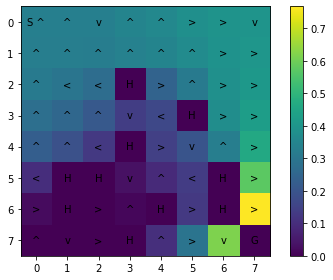

In [ ]:
plotQ(q_table_sarsa, 8)

Nous affichons une moyenne glissante (sur 1000 épisodes) des récompenses obtenues pendant l'apprentissage, c'est-à-dire la fréquence à laquelle l'agent atteint l'objectif .

Il est important d'afficher l'évolution de cette grandeur pendant l'entrainement car il peut y avoir des risques de "désapprentissage". En effet, au fur et à mesure que l'on se rapproche de la politique optimale, si le taux d'apprentissage est trop important, on peut s'éloigner de la solution. Le terme de correction peut ainsi nous faire dépasser la solution.

On remarque que l'agent s'améliore pendant les premiers épisodes, puis la récompenses moyennes oscillent autour de 35%. Cette moyenne est relativement faible, mais cela est en partie dû au fait que l'agent explore des actions non opitmales ϵ% du temps. Nous allons dans la suite évaluer la politique, en retirant la partie exploration.

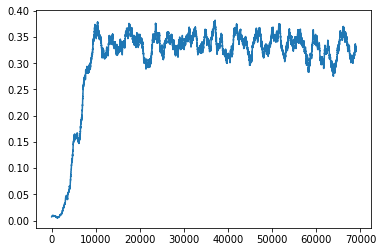

In [ ]:
recompenses_sarsa_lissage = runningAvg(recompenses_sarsa, windowSize=1000)
plt.plot(recompenses_sarsa_lissage)

Nous utilisons notre fonction *exploitation_politique* pour évaluer la politique extraite avec SARSA. Nous exploitons la politique sur 2000 épisodes  (sans exploration) et nous calculons la moyenne des récomposenses, c'est-à-dire la fréquence de réussite à atteindre l'objectif. Nous obtenons 86% de réussite avec le paramétrage actuel.

In [ ]:
recompenses_exploitation_sarsa = exploitation_politique(2000, gamma=1, q=q_table_sarsa)
print("Performances SARSA:", np.mean(recompenses_exploitation_sarsa))

Performances SARSA: 0.863


Voici maintenant l'évolution de la récompense moyenne (sur 20 épisodes, sans exploration) tous les 1000 épisodes pendant la phase d'apprentissage :


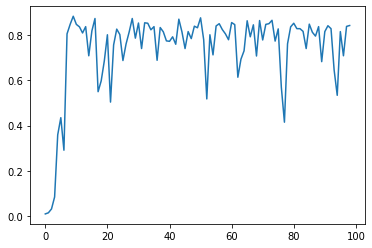

In [ ]:
plt.plot(evaluations_apprentissage)


On remarque que l'agent s'améliore rapidement sur les 10000 premiers épisodes. Il arrive à atteindre l'objectif 85% du temps. Passé ce stade, la récompense moyenne oscille autour de 80%. Quelque fois, l'agent n'arrive à atteindre l'objectif que 60 voire 40% du temps. Soit le nombre d'épisode est trop faible pour pouvoir représenter fidèlement les performances de l'agent, soit il s'agit d'un phénomène de "désapprentissage". Sachant que nous évaluons la politique sur 1000 épisodes, la probabilité que ce soit un phénomène de "désapprentissage" est forte.
Dans la suite, nous allons passer de paramétres constants à des paramétres dégressifs.

### Optimisation du paramétrage de SARSA

Il est possible d'améliorer notre paramétrage en diminuant les valeurs de $α$ et de $ϵ$ au bout d'un certain nombre d'itérations. Cela permet d'éviter le phénomène d'oscillation autour de la solution optimale (désapprentissage). 

Ici, nous faisons le choix d'une décroissance par paliers : 
On commence par des valeurs de ϵ et α relativement élevées puis on divise ϵ par 1.5 et α par 1.7 toutes les 10000 itérations. On commence par laisser le temps à l'agent d'explorer avant de basculer vers d'avantages d'exploitation. On fixe une borne inférieure pour ϵ à 0.15 car on veut continuer d'explorer pendant l'apprentissage.

100%|██████████| 70000/70000 [10:25<00:00, 111.93it/s]


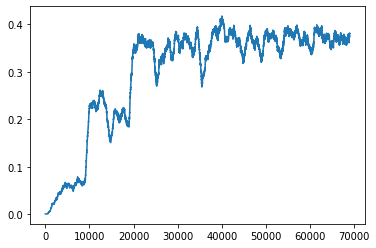

In [ ]:
q_table_sarsa_optimise,recompenses_sarsa_optimise,evaluations_apprentissage_opti = SARSA(70000, gamma=1, alpha=0.07, 
                                                                                         epsilon=0.5,mode_degressif="pallier",
                                                                                         debut_degressif=0,intervalle = 10000,
                                                                                         tau_alpha=1.5, tau_epsilon=1.7,
                                                                                         evaluation_politique=True,
                                                                                         nb_episode_evaluation=1000, 
                                                                                         evaluation_tous_les=1000)
recompenses_sarsa_optimise_lissage = runningAvg(recompenses_sarsa_optimise, windowSize=1000)
plt.plot(recompenses_sarsa_optimise_lissage)

En diminuant $ϵ$, la récompense moyenne augmente car on explore de moins en moins et on exploite plus la politique extraite. En diminuant α, on réduit en théorie la probabilité du "désapprentissage" pendant l'entrainement.

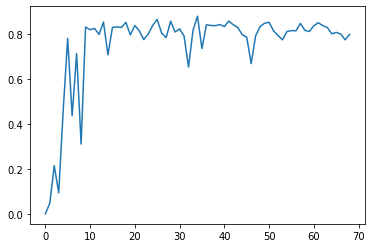

In [ ]:
plt.plot(evaluations_apprentissage_opti)


Avec le nouveau paramétrage de SARSA, nous arrivons à atteindre l'objectif 89% du temps. Avec plus d'itérations, l'agent pourrait trouver une meilleure politique et atteindre l'objectif à toutes les itérations (100%).

In [ ]:
recompenses_exploitation_sarsa_optimise = exploitation_politique(2000, gamma=1, q=q_table_sarsa_optimise)
print("Performances SARSA:", np.mean(recompenses_exploitation_sarsa_optimise))

Performances SARSA: 0.89


Ci-dessous, voici les actions préconisées par la politique extraite avec SARSA. Ces actions semblent a priori cohérentes avec l'objectif à atteindre et les obstacles.

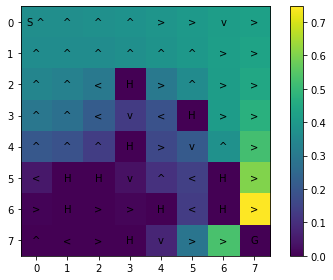

In [ ]:
plotQ(q_table_sarsa_optimise, 8)

Nous ne pouvons pas affirmer qu'il s'agit d'une politique optimale. Les conditions de convergence de SARSA dépendent de la nature de la dépendance de la politique à $Q$. Dans notre cas, une politique est dérivée de $Q$ à partir de la méthode $ϵ$-greedy. Nous avons des garanties de convergences théoriques, si toutes les paires (état, action) sont visités une infinité de fois et que le paramètre $ϵ$ décroit en 1/$t$.

# SARSA (décroissance de $ϵ$ en 1/t)

In [16]:
q_table_sarsa_optimise,recompenses_sarsa_optimise,evaluations_apprentissage_opti = SARSA(30000, gamma=0.95, alpha=0.03, 
                                                                                         epsilon=0.5,mode_degressif="continu",
                                                                                         debut_degressif=25000,
                                                                                         evaluation_politique=True,
                                                                                         nb_episode_evaluation=1000, 
                                                                                         evaluation_tous_les=1000)

100%|██████████| 30000/30000 [02:14<00:00, 222.77it/s]


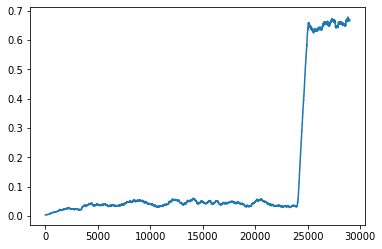

In [17]:
recompenses_sarsa_optimise_lissage = runningAvg(recompenses_sarsa_optimise, windowSize=1000)
plt.plot(recompenses_sarsa_optimise_lissage)

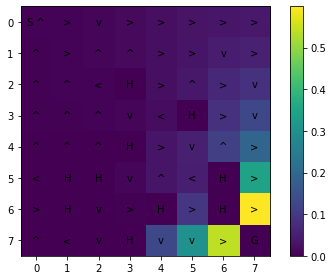

In [18]:
plotQ(q_table_sarsa_optimise, 8)

# Q-learning
Implémentez l'algorithme Q-learning (en partant de SARSA, il ne devrait y avoir que quelques lignes de codes à modifier!)



Contrairement à l'algorithme SARSA, Q-learning est off-policy, cela signifie que l'action $a'$ est choisie de façon "gloutonne". En effet, là où SARSA utilisait une politique issue de $Q$ pour choisir $a'$, ici Q-learning prend le max de $Q$ sur toutes les actions à partir de l'état $s'$. La politique utilisée pour générer les données n'est pas la politique que l'on cherche/optimise.

Ainsi, pendant l'apprentissage, on devrait observer des différences entre l'évaluation de la politique extraite sur quelques épisodes et la récompense moyenne avec la politique utilisée pour générée les données.

In [ ]:
def Q_learning(numEpisodes, gamma, alpha, epsilon, mode_degressif=False,debut_degressif=25000,intervalle = 5000,
               tau_alpha=1.5, tau_epsilon=1.05,evaluation_politique=False,nb_episode_evaluation=500,
               evaluation_tous_les=1000):
  
  q = np.zeros((numStates,numActions), dtype='float')
  lancement_du_compteur = False

  recompenses = []
  cpt = 0
  
  evaluations = []
  cpt_evaluation = 0


  for episode in tqdm(range(numEpisodes)):

    gameover = False
    state = env.reset()
    s = state
    a = epsGreedy(epsilon, q[s,:])
    Gt = 0.0

    if lancement_du_compteur :  
      cpt += 1

    # Décrément des valeurs de epsilon et du learning rate
    if mode_degressif:
      if episode > debut_degressif:
        lancement_du_compteur = True

      if cpt > intervalle:
        cpt = 0
        alpha =  max(0.01,alpha/tau_alpha) 
        epsilon =  max(0.15,epsilon/tau_epsilon) 


    if evaluation_politique:
      if cpt_evaluation > evaluation_tous_les:
        cpt_evaluation = 0
        recompenses_exploitation = exploitation_politique(nb_episode_evaluation, gamma=1, q=q)
        evaluations.append(np.mean(recompenses_exploitation))        

    cpt_evaluation += 1

    while True:
      s_p, r, gameover, info = env.step(a)
      Gt += r 

      # Si s_p est final
      if gameover:
        q[s,a] = q[s,a]+ alpha*(r-q[s,a])
        break

      # Politique "gloutonne" de Q learning (off policy)
      correction = r + gamma*np.max(q[s_p,:]) - q[s,a]
      q[s,a] = q[s,a] + alpha*correction      

      a_p = epsGreedy(epsilon, q[s_p,:]) 
      s = s_p   
      a = a_p
    
    recompenses.append(Gt)

  return q,recompenses,evaluations

Nous allons utiliser l'algorithme Q-learning sur 70000 épisodes avec γ=1. Pour le moment, nous choisissons des paramètres constants pour α et ϵ. 

In [ ]:
q_table_q_learning,recompenses_q_learning,evaluations_apprentissage_q_learning = Q_learning(70000, 1, 0.02, 0.2,
                                                                                            evaluation_politique=True,
                                                                                         nb_episode_evaluation=1000, 
                                                                                         evaluation_tous_les=1000)

100%|██████████| 70000/70000 [10:23<00:00, 112.22it/s]


Voici l'évolution de la récompense moyenne pendant l'apprentissage avec Q-learning. On rappelle que Q-learning est "off policy", c'est-à-dire qu'il évalue et améliore une politique qui est différente de celle utilisée pour la séléction des actions.

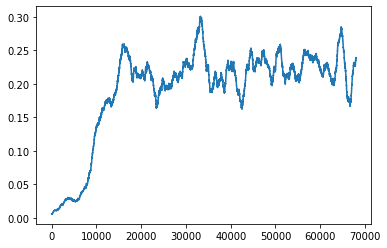

In [ ]:
recompenses_q_learning_lissage = runningAvg(recompenses_q_learning, windowSize=2000)
plt.plot(recompenses_q_learning_lissage)

Nous évaluons régulièrement la politique sur plusieurs épisodes (sans exploration). Voici l'évolution de la récompenses moyenne (sans exploration) pendant l'apprentissage :

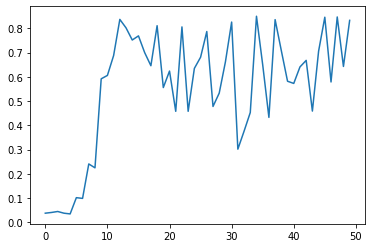

In [ ]:
plt.plot(evaluations_apprentissage_q_learning)

Ci-dessous figurent les actions préconisées par la politique extraite par Q-learning:

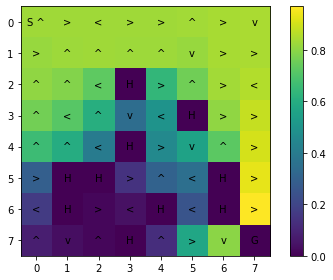

In [ ]:
plotQ(q_table_q_learning, 8)


On remarque que la politique extraite est cohérente vis-à-vis de l'objectif et de la position des trous. Les actions préconisées par Q-Learning ressemble globalement à celles préconisées par SARSA.

In [ ]:
recompenses_exploitation_q_learning = exploitation_politique(2000, gamma=1, q=q_table_q_learning)
print("Performances Qlearning:", np.mean(recompenses_exploitation_q_learning))

Performances Qlearning: 0.88


### Optimisation du paramétrage de Q-learning

Nous allons maintenant choisir de faire décroitre les paramètres \alpha et \epsilon par paliers. Nous fixons une borne inférieure pour ϵ à 0.15 :

In [ ]:
q_table_q_learning_optimise,recompenses_q_learning_optimise,evaluations_apprentissage_q_learning_optimise = Q_learning(100000, 1, 0.5, 0.5,mode_degressif=True,
                                                                                                                      debut_degressif=0,intervalle = 10000,
                                                                                                                      tau_alpha=2, tau_epsilon=1.5,
                                                                                                                      evaluation_politique=True,
                                                                                                                      nb_episode_evaluation=1000, 
                                                                                                                      evaluation_tous_les=1000)

100%|██████████| 100000/100000 [16:30<00:00, 100.96it/s]


Voici la réussite moyenne obtenue par l'algorithme Q-learning pendant l'apprentissage avec des paramètres dégressifs.

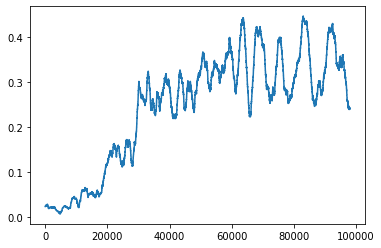

In [ ]:
recompenses_q_learning_optimise_lissage = runningAvg(recompenses_q_learning_optimise, windowSize=2000)
plt.plot(recompenses_q_learning_optimise_lissage)

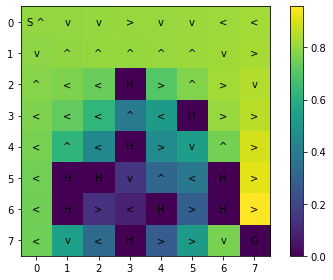

In [ ]:
plotQ(q_table_q_learning_optimise, 8)

In [ ]:
recompenses_exploitation_q_learning = exploitation_politique(2000, gamma=1, q=q_table_q_learning_optimise)
print("Performances Qlearning:", np.mean(recompenses_exploitation_q_learning))

Performances Qlearning: 0.905


On remarque que l'on arrive à atteindre 90% de réussite en exploitant sur 2000 épisodes la politique extraite avec Q-learning (paramétres dégréssifs).

Avec plus d'itérations, il serait peut-être poosible d'atteindre de meilleurs résultats.

## Comparaison entre SARSA et Q-learning

## Comparaison

Comparer les politiques trouvées à l'aide de SARSA, Q-learning, et vous devriez aussi pouvoir utiliser le code de l'algorithme on policy Monte Carlo du TD précédent.

Avant convergence à l'optimal, on observe souvent que SARSA a choisi une politique moins risquée avant de tomber sur l'optimal pour le FrozenLake8x8.

Sous les hypothèses GLEI , les deux algorithmes convergent vers une solution optimale. Nous allons dans un premier temps comparer les récompenses moyennes obtenues au fur à mesure de l'apprentissage (avec exploration).

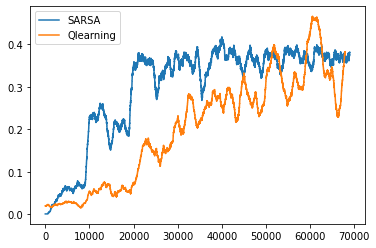

In [ ]:
plt.figure()
plt.plot(recompenses_sarsa_optimise_lissage)
plt.plot(recompenses_q_learning_optimise_lissage)
plt.legend(["SARSA","Qlearning"])

Nous remarquons que Q-learning a en moyenne une récompense inférieur à SARSA. Cela s'explique par le fait que Q-learning adopte une stratégie plus "gloutonne" que SARSA (terme $max(Q)$) pour choisir l'action $a'$. La politique utilisée par  Q-learning pendant l'apprentissage n'est pas celle qui est optimisée.


L'algorithme Q-learning a ainsi tendance à choisir un chemin "plus risqué" pour atteindre l'objectif alors que SARSA suit une politique à partir de la table $Q$ et donc prend un chemin "moins risqué". En moyenne, SARSA accumule donc plus de récompenses que Q-learning pendant l'apprentissage mais peut prendre plus de temps pour converger vers le chemin optimal. 



### Utilisation de l'algorithme Monte-Carlo "on policy"

Comme nous sommes dans un cas de figure épisodique, nous allons maintenant utiliser l'algorithme Monte-Carlo "on policy" pour extraire une politique optimale. Contrairement au Blackjack, ici les états peuvent se répéter, nous allons mettre en place la version "première visite" sur 200000 épisodes.

In [ ]:
import random
# On fait l'hypothèse que pi est un vecteur numpy de taille le nombre d'actions disponible
def draw(pi):
  if np.all(pi == pi[0]):
    # Si toutes valeurs de politiques sont identiques, 
    # on choisit aléatoirement une action
    return np.random.choice(list(range(len(pi))))
  else:
    return np.random.choice(list(range(len(pi))), p=pi)

def onPolicyMC(numEpisodes,numStates, gamma, epsilon):
    q = np.zeros((numStates,numActions), dtype='float')
    acc = np.zeros((numStates,numActions), dtype='float')
    n = np.zeros((numStates,numActions), dtype='float')  
    policy = np.zeros((numStates,numActions), dtype='float')

    recompenses = []
    cpt = 0
    for episode in tqdm(range(numEpisodes)):
        gameover = False
        visited = []

        cpt += 1

        s = env.reset()
        a = draw(np.ones(numActions)/numActions)
        visited.append((s,a))
        Gt = 0.0
        k = 0
        Gts = []
        while True:
            s,r,gameover,infos = env.step(a)  
            Gt = Gt + r*(gamma**k)            

            # On suit la politique pi
            a = draw(policy[s,:])

            # Calcul du gain à long terme
            if not (s,a) in visited: 
              visited.append((s,a))  

            if gameover:
              break                      
            
            k+=1
        recompenses.append(Gt)

        etats = set()
        for (etat,action) in visited:
            acc[etat,action] = acc[etat,action] + Gt
            n[etat,action] = n[etat,action] + 1
            q[etat,action] = acc[etat,action]/n[etat,action]
            etats.add(etat)
        
        for etat in etats:
          a_opti = np.argmax(q[etat,:])
          for action in range(numActions):
              if action == a_opti:
                policy[etat,action] = 1 - epsilon + epsilon/numActions
              else:
                policy[etat,action] = epsilon/numActions   
    return policy, q, recompenses

policy_MC,q_MC,recompenses_MC = onPolicyMC(numEpisodes=200000,numStates = numStates, gamma=1, epsilon=0.5)

100%|██████████| 200000/200000 [18:18<00:00, 182.05it/s]


Ci-dessous figurent les actions préconisées par la politique extraite par Monte Carlo "on Policy" sur le problème FrozenLake 8x8 :

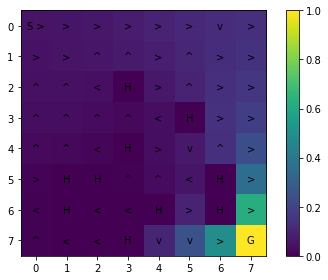

In [ ]:
plotQ(q_MC, 8)

Voici l'évolution de la récompense moyenne pendant l'apprentissage :

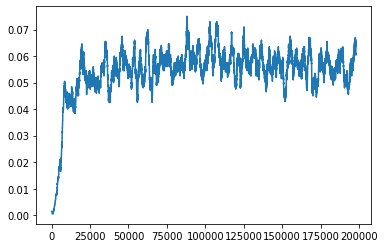

In [ ]:
recompenses_MC_lissage = runningAvg(recompenses_MC, windowSize=2000)
plt.plot(recompenses_MC_lissage)

In [ ]:
recompenses_exploitation_MC = exploitation_politique(1000, gamma=1, q=q_MC)
print("Performances Qlearning:", np.mean(recompenses_exploitation_MC))

Performances Qlearning: 0.935


### Modification du système de récompenses

J'ai également essayé de modifier le système de récompenses. Chaque déplacement entraine maintenant une pénalité de -0.5 et tomber dans un trou entraine une pénalité de -10

## Cart-pole en tabulaire

On vous propose pour finir d'utiliser votre code et de tester l'apprentissage sur le problème du cart-pole. A priori, c'est un problème où les états sont des variables continues. On vous propose ici de discrétiser les variables et d'essayer d'utiliser une des méthodes pour voir vos résultats. 

La récompense que vous obtenez est le nombre de pas de temps où le baton est resté en équilibre. Si vous utilisez colab pour coder, vous ne pourrez malheureusement pas visualiser un épisode avec la méthode render :-(

Cet environnement Cart-Pole consiste à déplacer un chariot pour faire tenir en équilibre une poutre. Plus précisément:
* Il y a deux actions : gauche et droite (représentées par 0 et 1).
* L'observation reçue (c'est à dire l'état) est un tableau numpy comprenant 4 variables: la position du chariot, la vélocité, l'angle à la verticale et la position du haut de la poutre.
* L'épisode se termine lorsque l'angle de la poutre à la verticale dépasse 12 degrés.
* Les récompenses reçues sont égales à 1 sauf si l'angle dépasse 12 degrés.

On vous donne ci-dessous les fonctions pour réaliser la discrétisation et pour encoder l'état en un entier.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import gym
env = gym.make("CartPole-v1")
print("environnement avec ", env.action_space.n, " actions")
print("l'espace des états est lui codé avec une class", env.observation_space,
      " qui représente un espace continu")
print("les bornes inférieures des intervalles sont: ", env.observation_space.low)
print("les bornes supérieures des intervalles sont: ",env.observation_space.high)
env.reset()
nbIt=0
done=False
while not done:
  observation, reward, done, info = env.step(np.random.randint(2))
  nbIt+=1
print("Episode terminé après {} itérations".format(nbIt))
env.close()

environnement avec  2  actions
l'espace des états est lui codé avec une class Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)  qui représente un espace continu
les bornes inférieures des intervalles sont:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
les bornes supérieures des intervalles sont:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Episode terminé après 11 itérations


In [ ]:
def discretise(x,mini,maxi): 
  # discretise x
  # renvoie un entier entre 0 et nval-1
  if x<mini: x=mini
  if x>maxi: x=maxi
  return int(np.floor((x-mini)*nval/(maxi-mini+0.0001)))

def encode(observation):
  pos = discretise(observation[0],mini=-1,maxi=1)
  vel = discretise(observation[1],mini=-1,maxi=1)
  angle = discretise(observation[2],mini=-1,maxi=1)
  pos2 = discretise(observation[3],mini=-1,maxi=1)
  return pos + vel*nval + angle*nval*nval + pos2*nval*nval*nval
  

In [ ]:
nval =5 # nombre de valeurs discrètes qu’une variable peut prendre
N= nval ** 4 # Puisqu’il y a 4 variables, la taille de l’espace est nval^4
print("Le nombre d'états sera ici de ", N)

Le nombre d'états sera ici de  625


In [ ]:
# Choix d'une action avec la méthode Epsilon Greedy
def epsGreedy(epsilon, q):
  exploration = np.random.binomial(1,epsilon)

  #quand le argmax n'est pas unique
  if exploration:
    return np.random.randint(len(q))
  else:

    maxs = np.argwhere(q == np.max(q)).ravel()

    if len(maxs) > 1:
      return np.random.choice(maxs)
    else:
      return np.argmax(q)

Modifiez votre implémentation de Q-learning et/ou de SARSA pour tester si vous pouvez apprendre à maintenier le baton en équilibre. Une modification sera d'utilisé les fonctions ci-dessus pour encoder/decoder un état. Une autre sera surement d'ajouter le nombre d'états en paramètre car ce nombre est maintenant indépendant de l'environnement! 
Avec comme paramètre $\epsilon=0.1$, $\alpha=0.2$ et $\gamma=0.9$, j'arrive a atteindre un score autour de 90 pas de temps.

In [ ]:
def Q_learning_CartPole(numEpisodes, gamma, alpha, epsilon, dec=True, start_dec=300000,tous_les = 100000, tau_alpha=1.02, tau_epsilon=1.02):
  numStates = 625
  numActions= 2
  q = np.zeros((numStates,numActions), dtype='float')
  compteur_lance = False
  cpt = 0

  recompenses = []
  tailles_episodes = []
  for episode in tqdm(range(numEpisodes)):
    gameover = False
    observation = env.reset()
    s = encode(observation)
    a = epsGreedy(epsilon, q[s,:])
    Gt = 0.0
    k = 0

    if dec:
      if episode > start_dec:
        compteur_lance = True
      if cpt > tous_les:
        cpt = 0
        alpha =  max(0.01,alpha/tau_alpha) 
        epsilon =  max(0.01,epsilon/tau_epsilon) 

    while not gameover:
      observation_p, r, gameover, info = env.step(a)
      s_p = encode(observation_p)
      Gt += r 

      # Si s_p est final
      if gameover:
        q[s,a] = q[s,a]+ alpha*(r-q[s,a])
        break
      
      max_q = np.max(q[s_p,:])  

      correction = r + gamma*max_q - q[s,a]
      q[s,a] = q[s,a] + alpha*correction      

      a_p = epsGreedy(epsilon, q[s_p,:]) 
      s = s_p   
      a = a_p
      Gt += Gt + r*gamma**k
      k += 1    
    recompenses.append(Gt)
    tailles_episodes.append(k)

  return q,recompenses,tailles_episodes


In [ ]:
q_table_q_learning_cartpole,recompenses_q_learning_cartpole,tailles_episodes = Q_learning_CartPole(20000, 0.9, 0.35, 0.3,dec=True, start_dec=300000,tous_les = 1000, tau_alpha=1, tau_epsilon=1.01)

100%|██████████| 30000/30000 [03:41<00:00, 135.50it/s]


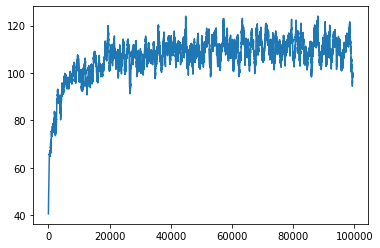

In [ ]:
def runningAvg(data, windowSize):
  res = np.zeros(len(data)-windowSize)
  sum=0
  for i in range(windowSize):
    sum += data[i]
  for i in range(len(data)-windowSize):
    res[i]= sum/windowSize
    sum -= data[i]
    sum += data[i+windowSize]
  return res

recompenses_q_learning_cartpole_lissage = runningAvg(recompenses_q_learning_cartpole, windowSize=2000)
tailles_episodes_lissage = runningAvg(tailles_episodes, windowSize=500)
plt.plot(tailles_episodes_lissage)

Le graphique ci-dessus représente l'évolution de la longueur de l'épisode (nombre d'itérations pendant laquelle on a arrive à maintenir la barre en équilibre) pendant la phase d'apprentissage.

In [ ]:
#Exploitation de la politique
def exploitation_politique_cartpole(numEpisodes, gamma, q):
  # q = np.zeros((numStates,numActions), dtype='float')
  tailles_episodes = []
  for episode in range(numEpisodes):
    gameover = False
    observation = env.reset()
    s = encode(observation)

    a = np.argmax(q[s,:])
    k = 0

    while True:

      #Execution de l'action a et observation de r      
      observation, r, gameover, info = env.step(a)
      s = encode(observation)

      # Si s_p est final
      if gameover:
        break
      
      #On choisir une action a_p depuis s_p à partir
      #de la politique de q
      a = np.argmax(q[s,:])
      
      k+=1  
    
    tailles_episodes.append(k)

  return tailles_episodes

In [ ]:
tailles_episodes_exploitation_q_learning_cartpole = exploitation_politique_cartpole(2000, gamma=0.9, q=q_table_q_learning_cartpole)
print("Performances Qlearning:", np.mean(tailles_episodes_exploitation_q_learning_cartpole))

Performances Qlearning: 181.7435


On remarque que notre version actuelle de Q-learning permet de maitenir la barre en équilibre pendant environ 181 itérations en moyenne sur 2000 épisodes.

## Implémentation de Deep Qlearning

Dans la suite, nous allons implémenter l'algorithme de Deep Qlearning et l'appliquer sur le problème du Cart Pole.

In [ ]:
from torch.nn import parameter
import torch
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear,Sequential,ReLU,MSELoss,LeakyReLU

class DeepQ_Learning():    
    def __init__(self, dim_etats, dim_actions, dim_couche_cachee=64, alpha=0.05):
            self.modele = Sequential(
                            Linear(dim_etats, dim_couche_cachee),
                            LeakyReLU(),
                            Linear(dim_couche_cachee, dim_couche_cachee*2),
                            LeakyReLU(),
                            Linear(dim_couche_cachee*2, dim_actions)
                    )
            self.fonction_cout = MSELoss()            
            self.algo_optimisation = Adam(self.modele.parameters(), alpha)   

    def predire_q(self, etat):
            """ Prédiction des valeurs de Q pour toutes les actions """
            with torch.no_grad():
                return self.modele(torch.Tensor(etat))
    def entrainement(self, etat, y):
            """Entrainement du réseau : mise à jour des poids (back propagation)"""
            pred = self.modele(torch.Tensor(etat))
            fonction_cout = self.fonction_cout(pred, Variable(torch.Tensor(y)))

            self.algo_optimisation.zero_grad()
            fonction_cout.backward()
            self.algo_optimisation.step()

In [ ]:
def epsilon_greedy(q,epsilon):
  exploration = np.random.binomial(1,epsilon)

  if exploration:
        action = env.action_space.sample()
  else:
        action = torch.argmax(q).item()
  return action

def Deep_Q_learning(env, modele, episodes, gamma=0.9, epsilon=0.3, eps_ratio=1.01):
    """Deep Q Learning algorithm using the DQN. """
    tailles_episodes = []

    for episode in tqdm(range(episodes)):      

        #Choix d'un espilon décroissant (minimum à 15%)
        epsilon = max(0.01,epsilon/eps_ratio)
        
        s = env.reset()
        gameover = False
        taille_episode = 0        
        while not gameover:

            # Selection de l'action avec epsilon greedy
            q = modele.predire_q(s)
            a = epsilon_greedy(q,epsilon)
            
            s_p, r, gameover, infos = env.step(a)
            
            
            taille_episode += r
            q = modele.predire_q(s).tolist()
             
            if gameover:                
                q[a] = r
                # Mise à jour des poids du réseau
                modele.entrainement(s, q)
                break 

            q_p = modele.predire_q(s_p)
            q[a] = r + gamma * torch.max(q_p).item()
            # Mise à jour des poids du réseau
            modele.entrainement(s, q)
            s = s_p
        
        tailles_episodes.append(taille_episode)
    return tailles_episodes,modele

In [ ]:
dim_état = 4
dim_action = 2
modele = DeepQ_Learning(4,2)
env = gym.make("CartPole-v1")

tailles_episodes_deep_q_learning,modele_entraine = Deep_Q_learning(env,modele,2000)

100%|██████████| 2000/2000 [00:55<00:00, 36.21it/s]


Voici l'évolution du nombre d'itérations d'un épisode p

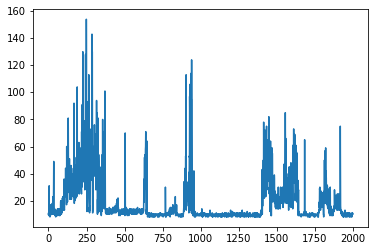

In [ ]:
def runningAvg(data, windowSize):
  res = np.zeros(len(data)-windowSize)
  sum=0
  for i in range(windowSize):
    sum += data[i]
  for i in range(len(data)-windowSize):
    res[i]= sum/windowSize
    sum -= data[i]
    sum += data[i+windowSize]
  return res
  
plt.plot(runningAvg(tailles_episodes_deep_q_learning, windowSize=1))

La fonction ci-dessous permet d'exploiter le modèle de Deep Q-learning (sans exploration) et de stocker le nombre d'itérations de chaque épisode :

In [ ]:
def Deep_Q_learning_exploitation(env, modele, episodes, gamma=0.9):
    tailles_episodes = []

    for episode in tqdm(range(episodes)):       
        
        s = env.reset()
        gameover = False
        taille_episode = 0
        
        while not gameover:
            q = modele.predire_q(s)
            a = torch.argmax(q).item()
            
            s, r, gameover, infos = env.step(a)
            
            taille_episode += 1
             
            if gameover:                
                break          

        tailles_episodes.append(taille_episode)
    return tailles_episodes

In [ ]:
tailles_episodes_deep_q_learning = Deep_Q_learning_exploitation(env,modele_entraine,2000)

100%|██████████| 2000/2000 [00:03<00:00, 547.69it/s]


In [ ]:
np.mean(tailles_episodes_deep_q_learning)


9.742

### Implémentation de Deep Q learning avec experience replay

Nous allons ajouter une mémoire à notre modèle pour pouvoir stocker les transitions $(s_t,a_t,r_{t+1},s_{t+1})$ en mémoire.

Cela permet d'améliorer la stabilité du réseau et de s'assurer que les expériences passées de l'agent ne soient pas oubliées pendant l'entraînement.

On va tirer aléatoirement des batchs d'expériences depuis la mémoire pour entrainer le réseau de neurones.



In [ ]:
from torch.nn import parameter
import torch
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear,Sequential,ReLU,MSELoss,LeakyReLU

class DeepQ_Learning_avec_memoire(DeepQ_Learning):  

  """
  Il s'agit d'une extension de la classe DeepQ_Learning avec
  la notion d'experience replay (échantillonnage dans les expériences passées)
  """
  def experience_replay(self, memoire, size, gamma=0.9):
      #On attend que la mémoire soit suffisamment grande avant de 
      #faire l'échantillonnage des expériences passées
        if len(memoire) >= size:
            etats = []
            y = []

            #Echantillonage d'un batch d'expériences passées 
            #depuis la mémoire
            batch_experiences = random.sample(memoire, size)
            
            for s, a, s_p, r, gameover in batch_experiences:
                etats.append(s)                
                q = self.predire_q(s).tolist()
                if gameover:
                    q[a] = r
                else:
                    q_p = self.predire_q(s_p)
                    q[a] = r + gamma * torch.max(q_p).item()
                y.append(q)
            self.entrainement(etats, y)


def Deep_Q_learning_avec_memoire(env, modele, episodes, gamma=0.9, epsilon=0.5, eps_decay=0.99,replay_size=20):
    tailles_episodes = []
    memoire = []
    for episode in tqdm(range(episodes)):               
        # Reset state
        s = env.reset()
        gameover = False
        taille_episode = 0
        epsilon = max(epsilon * eps_decay, 0.05)
        
        while not gameover:

            # Selection de l'action avec epsilon greedy
            q = modele.predire_q(s)
            a = epsilon_greedy(q,epsilon)
            
            s_p, r, gameover, _ = env.step(a)
            
            taille_episode += r
            #Stockage de la transition dans la mémoire
            memoire.append((s, a, s_p, r, gameover))
            
            q = modele.predire_q(s).tolist()
             
            if gameover:                
                break
              
            modele.experience_replay(memoire, replay_size, gamma)
            s = s_p
        
        
        tailles_episodes.append(taille_episode)
    return tailles_episodes,modele

In [ ]:
modele = DeepQ_Learning_avec_memoire(4,2)
env = gym.make("CartPole-v1")

tailles_episodes_deep_q_learning,modele_entraine = Deep_Q_learning_avec_memoire(env,modele,300)

100%|██████████| 300/300 [00:57<00:00,  5.18it/s]


Ci-dessous, nous avons afficher l'évolution de la récompense pendant l'apprentissage. On rappelle que pendant cette phase, on explore une action aléatoire avec une probabilité ϵ. Cela explique pourquoi l'épisode est souvent court.

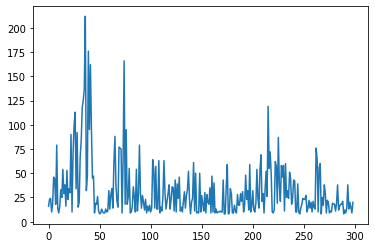

In [ ]:
plt.plot(runningAvg(tailles_episodes_deep_q_learning, windowSize=1))


Pour évaluer les performances du modèle, on va l'exploiter (sans exploration) sur 1000 épisodes: 

In [ ]:
tailles_episodes_deep_q_learning = Deep_Q_learning_exploitation(env,modele_entraine,1000)


100%|██████████| 1000/1000 [01:28<00:00, 11.28it/s]


La figure ci-dessous montre l'évolution de la taille de l'épisode sur 1000 épisodes (sans exploration) :

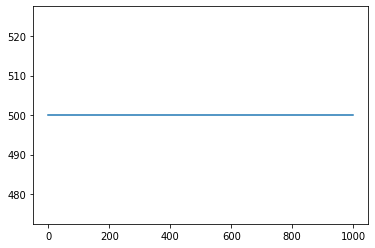

In [ ]:
plt.plot(tailles_episodes_deep_q_learning)


On remarque que notre modèle arrive à atteindre le nombre d'itérations maximales pour le problème Cart Pole pour 1000 épisodes.



In [ ]:
np.mean(tailles_episodes_deep_q_learning)


500.0

Le modèle a été enregistré dans le fichier modele_deepQN_CartPole.pkl fourni avec le notebook. Il s'agit d'un objet de la classe DeepQ_Learning_avec_memoire. Cet peut être chargé avec le module pickle avec la commande ci_dessous :

In [ ]:
import pickle
from torch.nn import parameter
import torch
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear,Sequential,ReLU,MSELoss,LeakyReLU
import gym
from  tqdm import tqdm

class DeepQ_Learning_avec_memoire():    
    def __init__(self, dim_etats, dim_actions, dim_couche_cachee=64, alpha=0.05):
            self.modele = Sequential(

                            Linear(dim_etats, dim_couche_cachee),
                            LeakyReLU(),
                            Linear(dim_couche_cachee, dim_couche_cachee*2),
                            LeakyReLU(),
                            Linear(dim_couche_cachee*2, dim_actions)
                    )
            self.fonction_cout = MSELoss()            
            self.algo_optimisation = Adam(self.modele.parameters(), alpha)   

    def predire_q(self, s):
            """ Prédiction des valeurs de Q pour toutes les actions """
            with torch.no_grad():
                return self.modele(torch.Tensor(s))
    def entrainement(self, s, y):
            """Entrainement du réseau : mise à jour des poids (back propagation)"""
            pred = self.modele(torch.Tensor(s))
            fonction_cout = self.fonction_cout(pred, Variable(torch.Tensor(y)))

            self.algo_optimisation.zero_grad()
            fonction_cout.backward()
            self.algo_optimisation.step()

    def experience_replay(self, memoire, size, gamma=0.9):
      #On attend que la mémoire soit suffisamment grande avant de 
      #faire l'échantillonnage des expériences passées
        if len(memoire) >= size:
            etats = []
            y = []

            #Echantillonage d'un batch d'expériences passées 
            #depuis la mémoire
            batch_experiences = random.sample(memoire, size)
            
            for s, a, s_p, r, gameover in batch_experiences:
                etats.append(s)                
                q = self.predire_q(s).tolist()
                if gameover:
                    q[a] = r
                else:
                    q_p = self.predire_q(s_p)
                    q[a] = r + gamma * torch.max(q_p).item()
                y.append(q)
            self.entrainement(etats, y)

def Deep_Q_learning_exploitation(env, modele, episodes, gamma=0.9):
    tailles_episodes = []

    for episode in tqdm(range(episodes)):       
        
        s = env.reset()
        gameover = False
        taille_episode = 0
        
        while not gameover:
            q = modele.predire_q(s)
            a = torch.argmax(q).item()
            
            s, r, gameover, infos = env.step(a)
            
            taille_episode += 1
             
            if gameover:                
                break          

        tailles_episodes.append(taille_episode)
    return tailles_episodes

with open("modele_deepQN_CartPole.pkl", "rb") as f:
  model = pickle.load(f)

On peut ensuite exploiter le modèle sur 1000 épisodes :

In [ ]:
env = gym.make("CartPole-v1")

#Exploitation du modèle sur 1000 épisodes
tailles_episodes_deep_q_learning = Deep_Q_learning_exploitation(env,model,1000)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(tailles_episodes_deep_q_learning)